In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load NEO - Near Earth Object Detection Dataset
df = pd.read_csv("neo_data.csv")
encoder=LabelEncoder()
# Drop unique identifier features
disc_val_col=['is_potentially_hazardous_asteroid', 'is_sentry_object','orbit_class_description','orbit_class_type']
for i in disc_val_col:
    df[i]=encoder.fit_transform(df[i])
junk_features=['Unnamed: 0','id', 'neo_reference_id', 'name', 'name_limited','designation','orbit_id']
df.drop(junk_features, axis=1, inplace=True)
df.head()

,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
0,15.22,1,0,2.401900,5.370812,1,0.621512,2.931360,1973-03-06,2021-10-20,3
1,15.97,0,0,1.700415,3.802244,0,1.238537,4.047945,1963-10-16,2021-04-15,1
2,16.36,0,0,1.420872,3.177167,0,1.050403,3.478155,1960-10-22,2021-06-12,1
3,17.10,0,0,1.010543,2.259644,2,0.790185,1.143633,1955-12-17,2019-11-10,2
4,17.28,0,0,0.930154,2.079888,1,0.701397,1.454804,1977-04-24,2021-12-02,3


In [ ]:
missing_columns = ['kilometers_estimated_diameter_max', 'kilometers_estimated_diameter_min', 'absolute_magnitude_h','last_observation_date','first_observation_date']
missing_data_count = df[missing_columns].isnull().any(axis=1).sum()
total_missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing data in the specified columns: {missing_data_count}")
print(f"Number of rows with missing data in any column: {total_missing_rows}")

Number of rows with missing data in the specified columns: 15
Number of rows with missing data in any column: 15


In [ ]:
"""
df['kilometers_estimated_diameter_max']=df['kilometers_estimated_diameter_max'].fillna(df['kilometers_estimated_diameter_max'].mean())
df['kilometers_estimated_diameter_min']=df['kilometers_estimated_diameter_min'].fillna(df['kilometers_estimated_diameter_min'].mean())
df['absolute_magnitude_h']=df['absolute_magnitude_h'].fillna(df['absolute_magnitude_h'].mean())
"""
df.dropna(subset=missing_columns, inplace=True)
df['mean_estimated_diameter_km'] = (df['kilometers_estimated_diameter_min'] + df['kilometers_estimated_diameter_max']) / 2
df["first_observation_date_parsed"] = pd.to_datetime(df["first_observation_date"], errors="coerce", format="mixed")
df["last_observation_date_parsed"] = pd.to_datetime(df["last_observation_date"], errors="coerce", format="mixed")

df["obs_span_days"] = (df["last_observation_date_parsed"] - df["first_observation_date_parsed"]).dt.days
df["perihelion_distance_km"] = df["perihelion_distance"] * 1.496e+8
df["semi_major_axis"] = (df["perihelion_distance"] + df["aphelion_distance"]) / 2
df["eccentricity"] = (df["aphelion_distance"] - df["perihelion_distance"]) / (df["aphelion_distance"] + df["perihelion_distance"])
df["orbit_radius_range"] = df["aphelion_distance"] - df["perihelion_distance"]
df["inv_perihelion"] = 1 / (df["perihelion_distance"] + 1e-6)
df["diameter_x_eccentricity"] = df["mean_estimated_diameter_km"] * df["eccentricity"]
df["mag_x_diameter"] = df["absolute_magnitude_h"] * df["mean_estimated_diameter_km"]

drops = ["first_observation_date", "last_observation_date",'perihelion_distance','first_observation_date_parsed','last_observation_date_parsed']
df.drop(drops, axis=1, inplace=True)
df.dropna(subset = 'obs_span_days', inplace=True)
print("Number of rows:", len(df))

Number of rows: 23984


In [ ]:
"""
This is printing the parameter means if the asteroid is hazardous or not. 0 being safe, 1 being hazardous.
"""
df.groupby('is_potentially_hazardous_asteroid').mean()

,absolute_magnitude_h,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,aphelion_distance,orbit_class_description,mean_estimated_diameter_km,obs_span_days,perihelion_distance_km,semi_major_axis,eccentricity,orbit_radius_range,inv_perihelion,diameter_x_eccentricity,mag_x_diameter
is_potentially_hazardous_asteroid,,,,,,,,,,,,,,,,
0,23.214641,0.048193,0.151898,0.339654,0.674387,2.639732,2.119593,0.245776,1348.863323,1.391294e+08,1.784871,0.434669,1.709723,1.191169,0.122876,4.754840
1,20.095130,0.005256,0.333668,0.746105,1.032967,2.796903,2.795031,0.539886,4086.998567,1.137231e+08,1.778542,0.534277,2.036722,1.532239,0.297575,10.152483


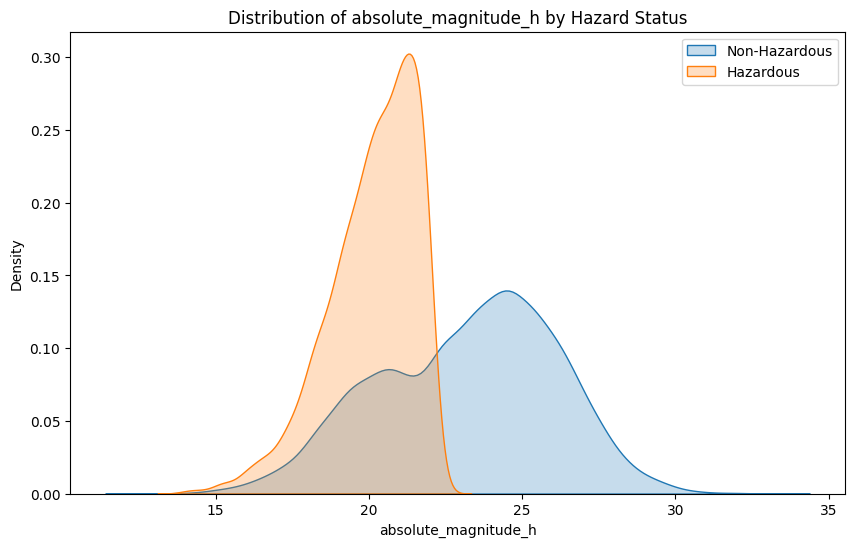

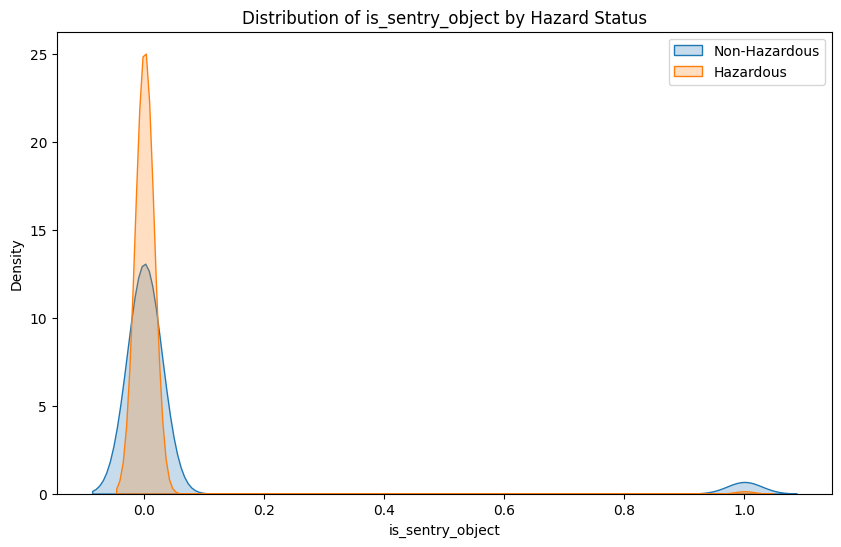

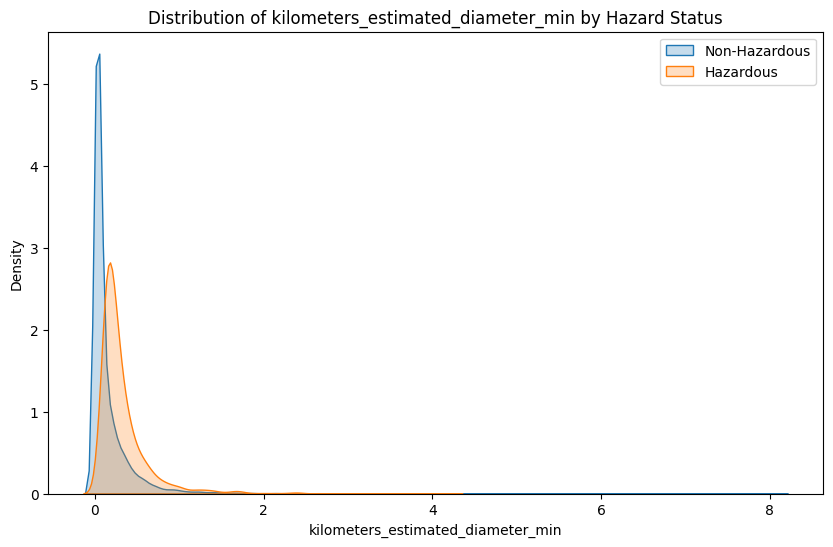

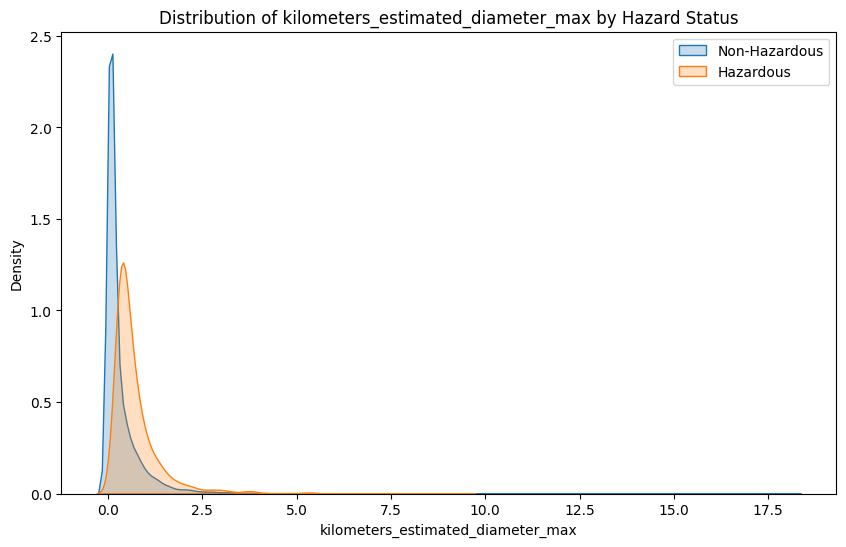

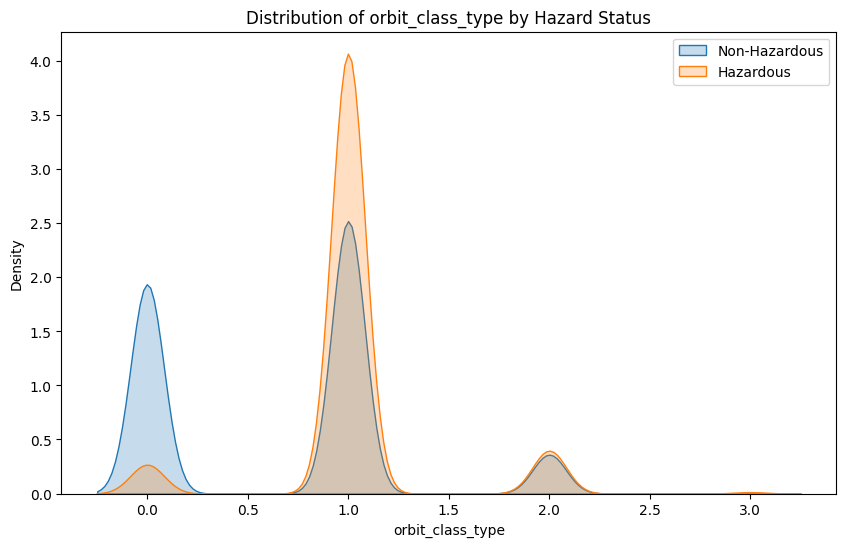

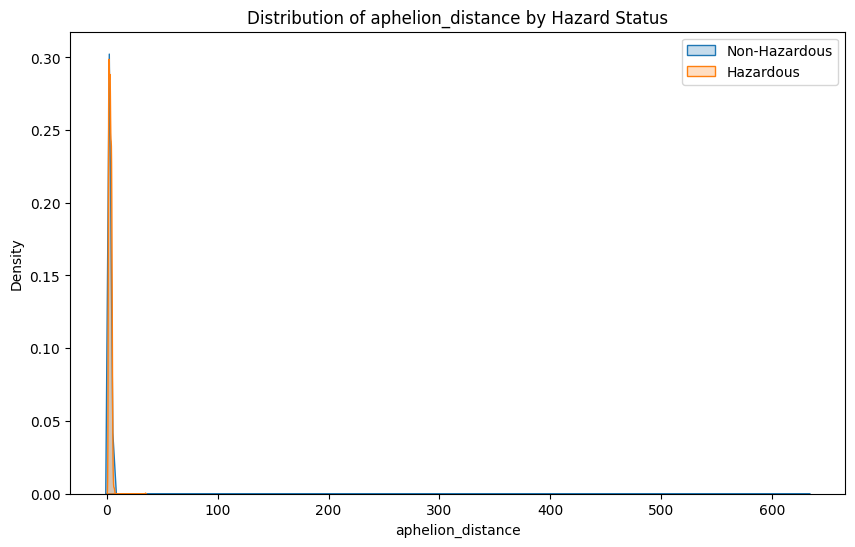

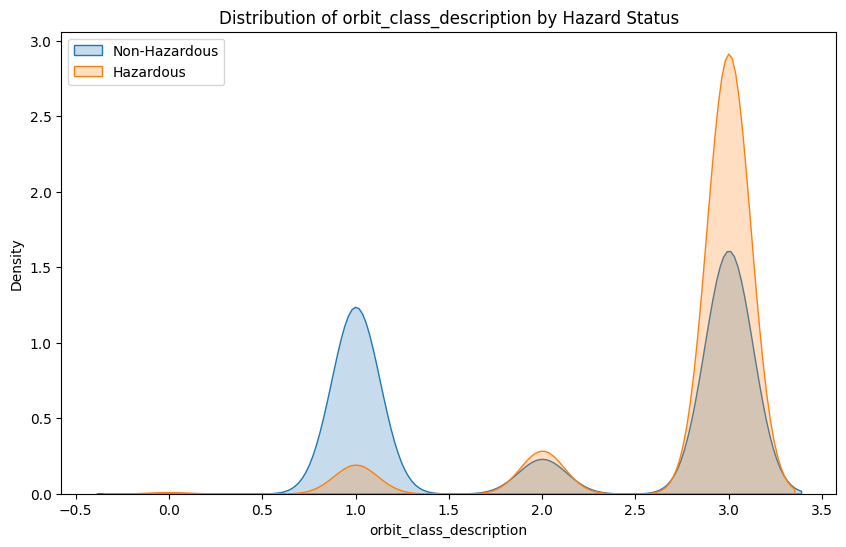

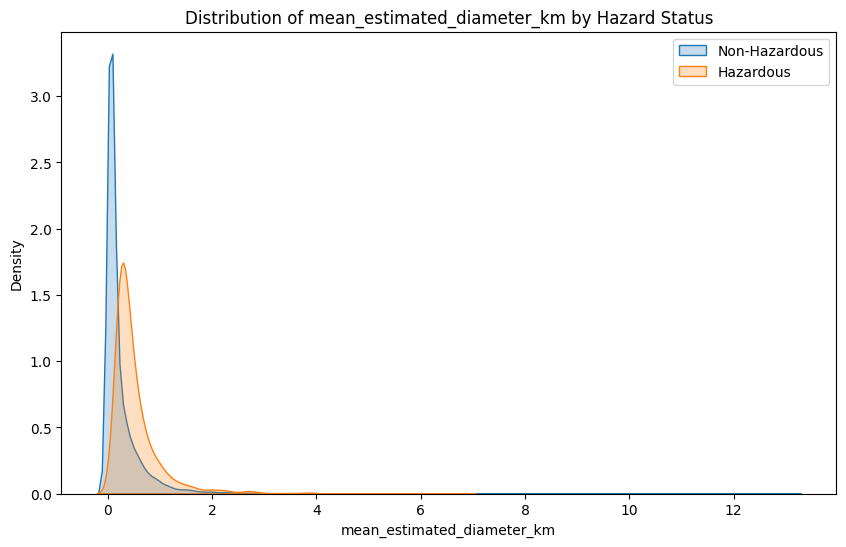

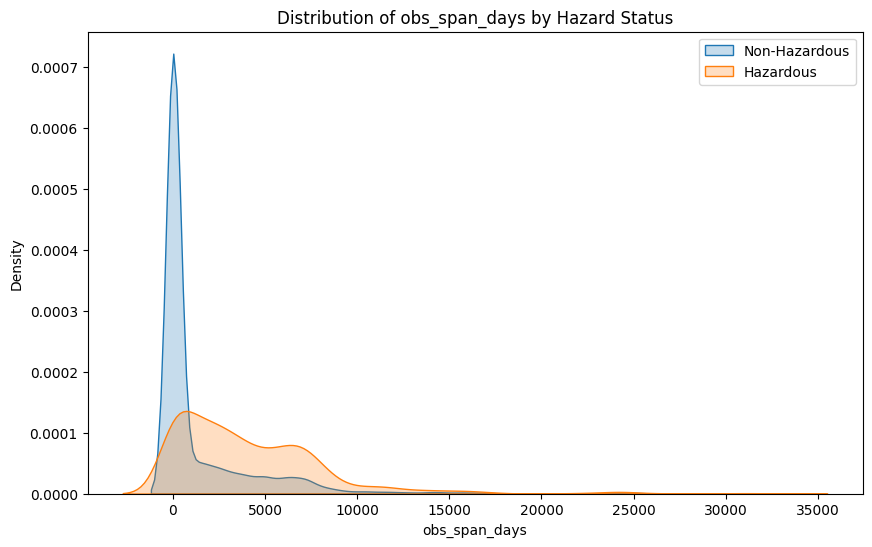

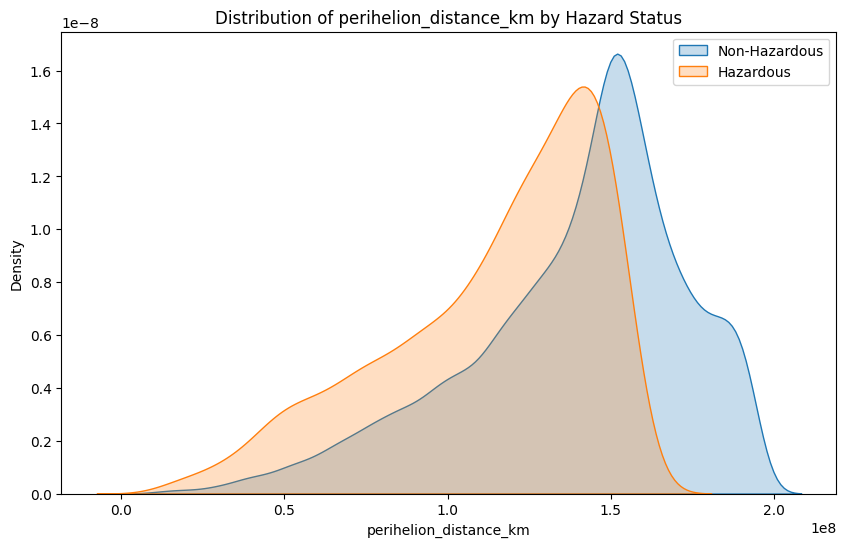

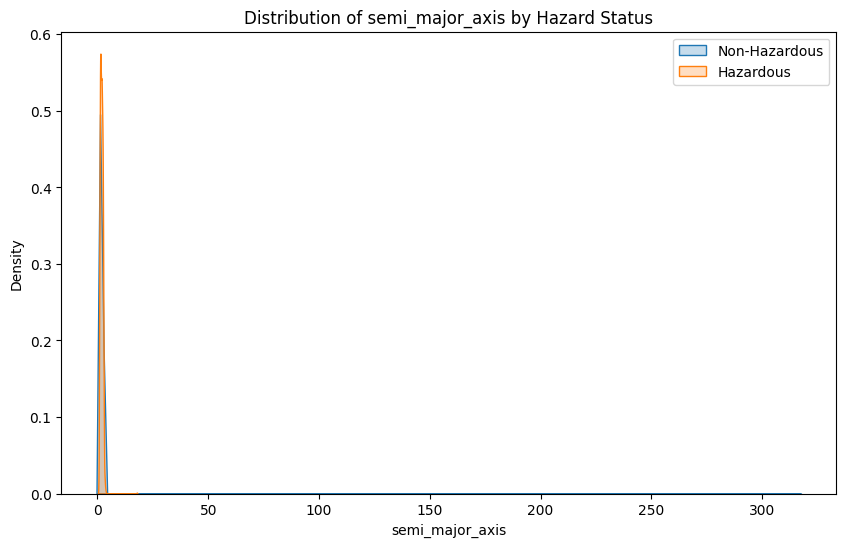

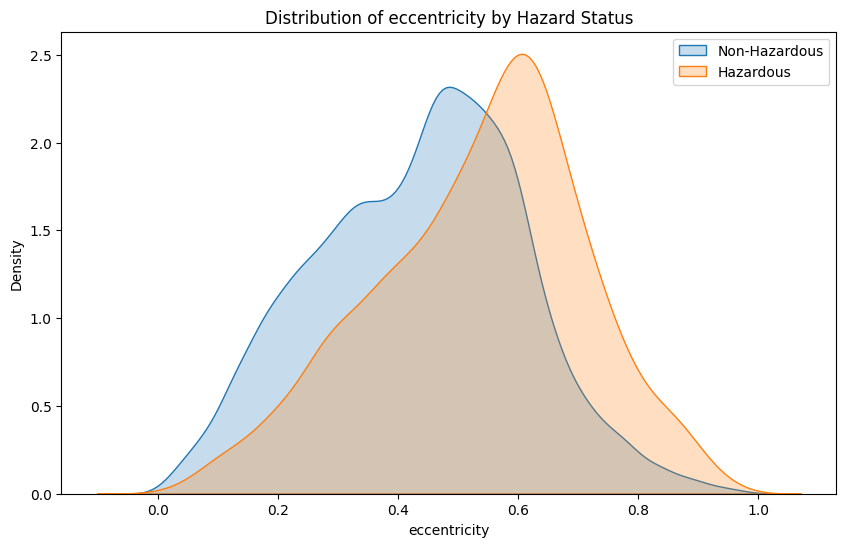

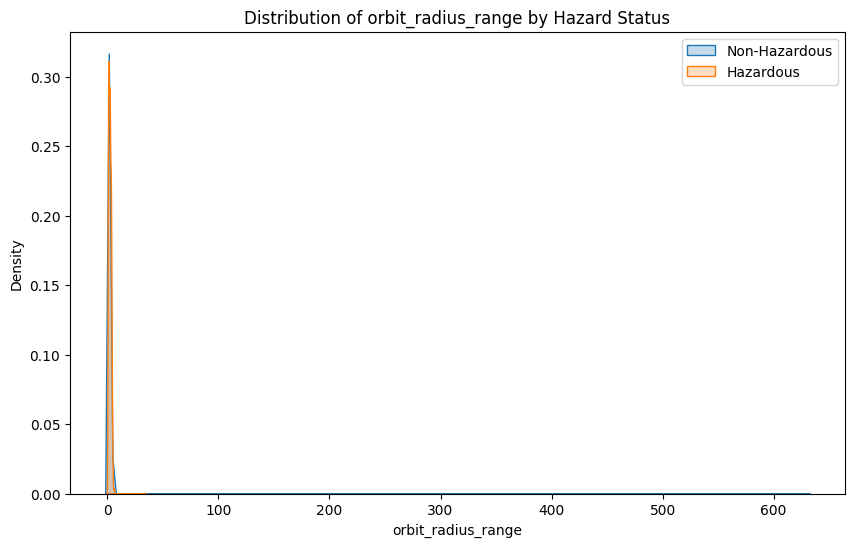

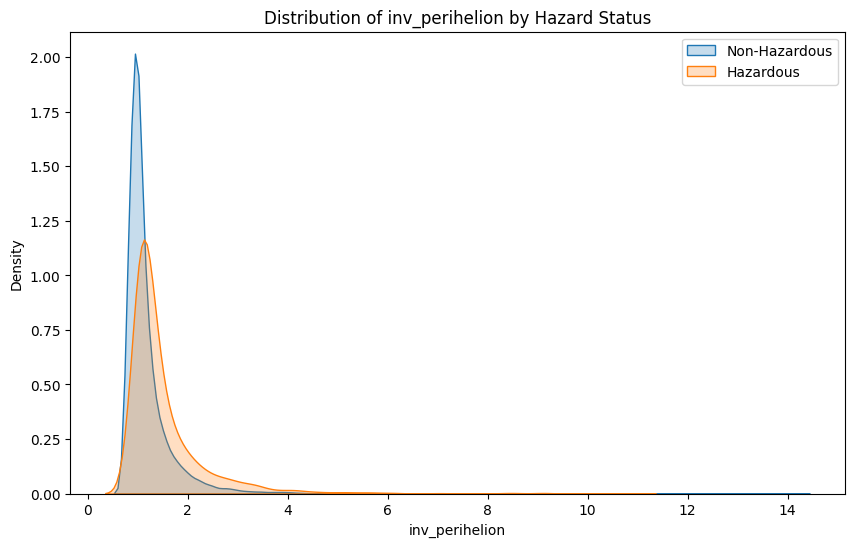

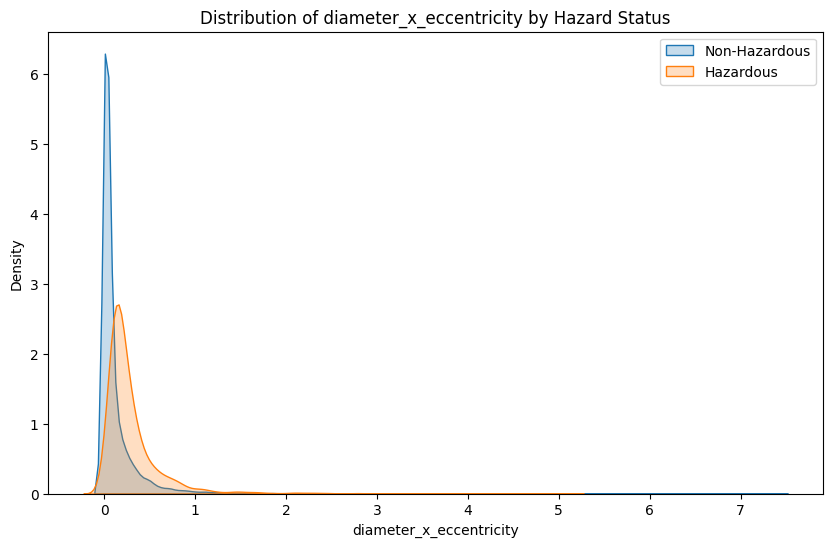

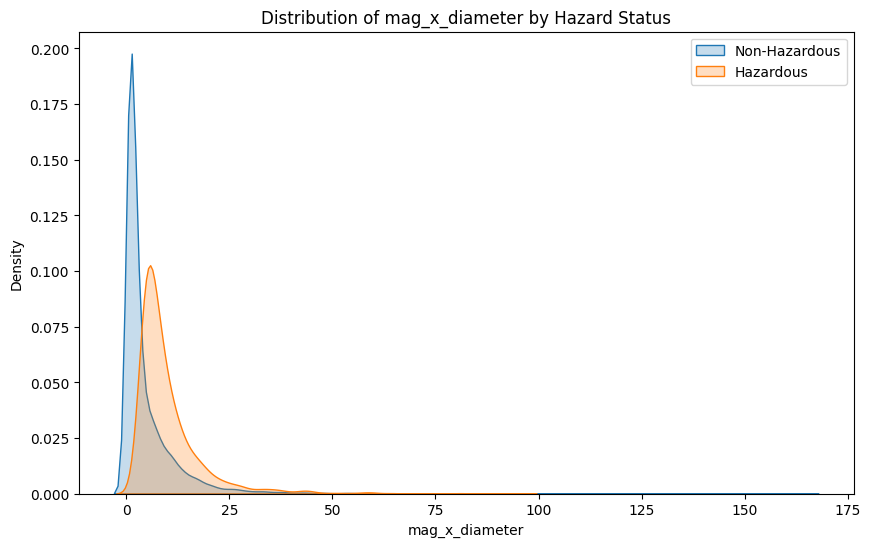

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get numerical columns excluding 'is_potentially_hazardous_asteroid'
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'is_potentially_hazardous_asteroid' in numerical_cols:
    numerical_cols.remove('is_potentially_hazardous_asteroid')

# Generate PDF plots for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df['is_potentially_hazardous_asteroid'] == 0][col], label='Non-Hazardous', fill=True)
    sns.kdeplot(df[df['is_potentially_hazardous_asteroid'] == 1][col], label='Hazardous', fill=True)
    plt.title(f'Distribution of {col} by Hazard Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

    plt.show()

<Axes: >

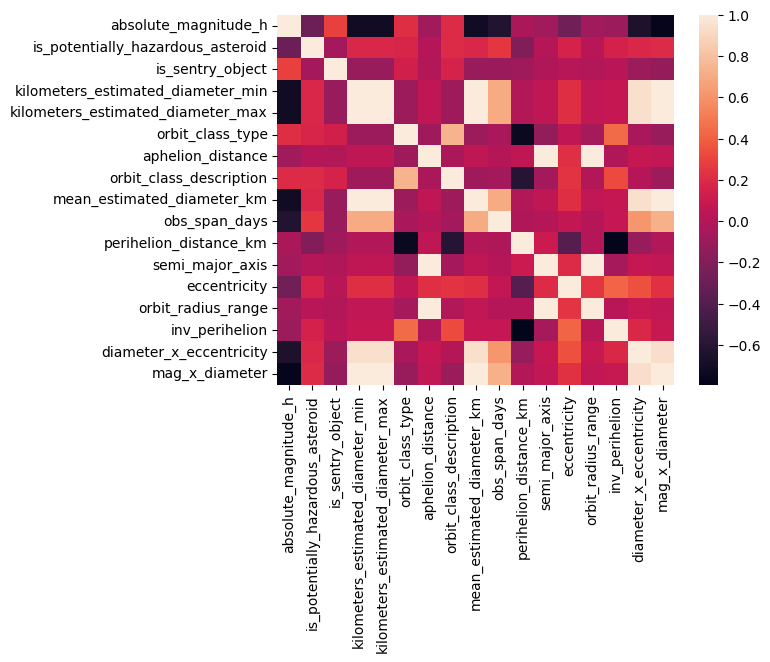

In [ ]:
sns.heatmap(df.corr())

In [ ]:
correlation_to_hazardous = df.corr()['is_potentially_hazardous_asteroid']
display(correlation_to_hazardous)

,is_potentially_hazardous_asteroid
absolute_magnitude_h,-0.298140
is_potentially_hazardous_asteroid,1.000000
is_sentry_object,-0.058802
kilometers_estimated_diameter_min,0.175068
kilometers_estimated_diameter_max,0.175068
orbit_class_type,0.167707
aphelion_distance,0.009924
orbit_class_description,0.201452
mean_estimated_diameter_km,0.175068
obs_span_days,0.245532


In [ ]:
from sklearn.tree import DecisionTreeClassifier
Treemodel=DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
Forestmodel=RandomForestClassifier()
from sklearn.linear_model import LogisticRegression
Logmodel=LogisticRegression()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Linearmodel=LinearDiscriminantAnalysis()

In [ ]:
import numpy as np
Chosen_Columns = np.array(df[['orbit_class_description','perihelion_distance_km','obs_span_days', 'absolute_magnitude_h', 'diameter_x_eccentricity','eccentricity','orbit_radius_range','mean_estimated_diameter_km','mag_x_diameter']])
Target = np.array(df['is_potentially_hazardous_asteroid'])
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(Chosen_Columns, Target,random_state=0)
Treemodel.fit(X_train,y_train)
Forestmodel.fit(X_train,y_train)
Logmodel.fit(X_train,y_train)
Linearmodel.fit(X_train,y_train)

print("Decision Tree - Train Score:", Treemodel.score(X_train, y_train), "Test Score:", Treemodel.score(X_test, y_test))
print("Random Forest - Train Score:", Forestmodel.score(X_train, y_train), "Test Score:", Forestmodel.score(X_test, y_test))
print("Logistic Regression - Train Score:", Logmodel.score(X_train, y_train), "Test Score:", Logmodel.score(X_test, y_test))
print("Linear Discriminant Analysis - Train Score:", Linearmodel.score(X_train, y_train), "Test Score:", Linearmodel.score(X_test, y_test))

Decision Tree - Train Score: 1.0 Test Score: 0.9099399599733156
Random Forest - Train Score: 1.0 Test Score: 0.9234489659773182
Logistic Regression - Train Score: 0.9067155881698911 Test Score: 0.9147765176784523
Linear Discriminant Analysis - Train Score: 0.8986546586613298 Test Score: 0.9067711807871914


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dt_params = {
    "max_depth": randint(1, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "criterion": ["gini", "entropy"]
}
dt_search = RandomizedSearchCV(Treemodel, dt_params, n_iter=50, cv=5, scoring="accuracy", n_jobs=-1, random_state=42)
dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_
for param, value in dt_search.best_params_.items():
    print(f"{param}: {value}")

criterion: entropy
max_depth: 7
min_samples_leaf: 3
min_samples_split: 3


In [ ]:
rf_params = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(5, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2", 0.5],
    "bootstrap": [True, False]
}
rf_search = RandomizedSearchCV(Forestmodel, rf_params, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
for param, value in rf_search.best_params_.items():
    print(f"{param}: {value}")

bootstrap: True
max_depth: 8
max_features: sqrt
min_samples_leaf: 3
min_samples_split: 4
n_estimators: 121


In [ ]:
log_params = {
    "penalty": ["l2", None],
    "C": uniform(0.001, 10),
    "solver": ["saga", "lbfgs", "newton-cg"]
}
log_search = RandomizedSearchCV(Logmodel, log_params, n_iter=50, cv=5, scoring="accuracy", n_jobs=-1, random_state=42)
log_search.fit(X_train, y_train)
best_log = log_search.best_estimator_
for param, value in log_search.best_params_.items():
    print(f"{param}: {value}")

C: 7.320939418114051
penalty: l2
solver: saga


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV

lda_param_grid = [
    {
        "solver": ["svd"],
        "shrinkage": [None]
    },
    {
        "solver": ["lsqr", "eigen"],
        "shrinkage": ["auto"] + [x / 10 for x in range(1, 10)]
    }
]

lda_search = GridSearchCV(Linearmodel, lda_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
lda_search.fit(X_train, y_train)
best_lda = lda_search.best_estimator_
for param, value in lda_search.best_params_.items():
    print(f"{param}: {value}")

shrinkage: 0.1
solver: lsqr


In [ ]:
from sklearn.metrics import accuracy_score
models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Logistic Regression": best_log,
    "LDA": best_lda
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
print(results_df)



                 Model  Accuracy
0        Decision Tree  0.918112
1        Random Forest  0.925117
2  Logistic Regression  0.917945
3                  LDA  0.914777


In [ ]:
print("Decision Tree - Train Score (Tuned):", best_dt.score(X_train, y_train), "Test Score (Tuned):", best_dt.score(X_test, y_test))
print("Random Forest - Train Score (Tuned):", best_rf.score(X_train, y_train), "Test Score (Tuned):", best_rf.score(X_test, y_test))
print("Logistic Regression - Train Score (Tuned):", best_log.score(X_train, y_train), "Test Score (Tuned):", best_log.score(X_test, y_test))
print("Linear Discriminant Analysis - Train Score (Tuned):", best_lda.score(X_train, y_train), "Test Score (Tuned):", best_lda.score(X_test, y_test))

Decision Tree - Train Score (Tuned): 0.9169446297531688 Test Score (Tuned): 0.9181120747164776
Random Forest - Train Score (Tuned): 0.9330664887702913 Test Score (Tuned): 0.9251167444963309
Logistic Regression - Train Score (Tuned): 0.9109962197020236 Test Score (Tuned): 0.9179452968645764
Linear Discriminant Analysis - Train Score (Tuned): 0.9088281076273071 Test Score (Tuned): 0.9147765176784523


In [ ]:
# Neural Network Classifier for NEO Hazard Prediction

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = Chosen_Columns
y = Target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

# Train
nn_model.fit(X_train_scaled, y_train)
# Predict
y_pred = nn_model.predict(X_test_scaled)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Neural Network Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Neural Network Accuracy: 0.9212007504690432

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4378
           1       0.57      0.38      0.46       419

    accuracy                           0.92      4797
   macro avg       0.76      0.68      0.71      4797
weighted avg       0.91      0.92      0.91      4797


Confusion Matrix:
[[4261  117]
 [ 261  158]]
